In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pybaseball import statcast, cache
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import joblib
import math
from pybaseball import statcast
import scipy.stats as stats
from catboost import Pool
import optuna
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, precision_score
import sqlite3
cache.enable()

In [2]:
with sqlite3.connect("../../Desktop/MLB Statcast.db") as conn:
    sc_23 = pd.read_sql_query("SELECT * FROM statcast_data_2023", conn)
    sc_22 = pd.read_sql_query("SELECT * FROM statcast_data_2022", conn)
    sc_21 = pd.read_sql_query("SELECT * FROM statcast_data_2021", conn)
    sc_20 = pd.read_sql_query("SELECT * FROM statcast_data_2020", conn)
conn.close()

In [3]:
spin_23 = pd.read_csv('../../Documents/spin_dir_2023.csv').drop(columns=['release_speed'])
spin_22 = pd.read_csv('../../Documents/spin_dir_2022.csv').drop(columns=['release_speed'])
spin_21 = pd.read_csv('../../Documents/spin_dir_2021.csv').drop(columns=['release_speed'])
spin_20 = pd.read_csv('../../Documents/spin_dir_2020.csv').drop(columns=['release_speed'])

In [4]:
sc_23 = pd.merge(sc_23, spin_23, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')
sc_22 = pd.merge(sc_22, spin_22, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')
sc_21 = pd.merge(sc_21, spin_21, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')
sc_20 = pd.merge(sc_20, spin_20, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')

In [5]:
total_sc = pd.concat([sc_23, sc_22, sc_21, sc_20])

In [6]:
total_sc

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,diff_measured_inferred_minutes,hawkeye_measured_clock_hh,hawkeye_measured_clock_mm,movement_inferred_clock_hh,movement_inferred_clock_mm,diff_clock_hh,diff_clock_mm,hawkeye_measured_clock_label,movement_inferred_clock_label,diff_clock_label
0,FS,2023-03-30 00:00:00,87.0,-0.32,6.82,"Bautista, Félix",594807,642585,strikeout,swinging_strike,...,0.0,1.0,30.0,1.0,30.0,0.0,0.0,01:30:00,01:30:00,0H 00M
1,FF,2023-03-30 00:00:00,99.3,-0.29,6.91,"Bautista, Félix",594807,642585,None,foul,...,-30.0,12.0,15.0,12.0,45.0,0.0,30.0,12:15:00,12:45:00,-0H 30M
2,FF,2023-03-30 00:00:00,97.5,-0.24,6.88,"Bautista, Félix",594807,642585,None,called_strike,...,-30.0,12.0,15.0,12.0,45.0,0.0,30.0,12:15:00,12:45:00,-0H 30M
3,FF,2023-03-30 00:00:00,96.9,-0.52,6.85,"Bautista, Félix",807799,642585,force_out,hit_into_play,...,-30.0,12.0,15.0,12.0,45.0,0.0,30.0,12:15:00,12:45:00,-0H 30M
4,FF,2023-03-30 00:00:00,97.5,-0.56,6.88,"Bautista, Félix",807799,642585,None,swinging_strike,...,-30.0,12.0,15.0,12.0,45.0,0.0,30.0,12:15:00,12:45:00,-0H 30M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279767,FF,2020-07-23 00:00:00,96.1,-3.28,5.13,"Scherzer, Max",543305,453286,field_out,hit_into_play,...,15.0,1.0,30.0,1.0,15.0,0.0,15.0,01:30:00,01:15:00,+0H 15M
279768,CU,2020-07-23 00:00:00,79.7,-3.36,5.48,"Scherzer, Max",543305,453286,None,called_strike,...,30.0,8.0,15.0,7.0,45.0,0.0,30.0,08:15:00,07:45:00,+0H 30M
279769,FF,2020-07-23 00:00:00,96.7,-3.21,5.33,"Scherzer, Max",543305,453286,None,called_strike,...,15.0,1.0,30.0,1.0,15.0,0.0,15.0,01:30:00,01:15:00,+0H 15M
279770,FF,2020-07-23 00:00:00,96.1,-3.38,5.33,"Scherzer, Max",543305,453286,None,ball,...,15.0,1.0,30.0,1.0,15.0,0.0,15.0,01:30:00,01:15:00,+0H 15M


In [7]:
[c for c in total_sc.columns]

['pitch_type',
 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'player_name',
 'batter',
 'pitcher',
 'events',
 'description',
 'spin_dir',
 'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
 'game_type',
 'stand',
 'p_throws',
 'home_team',
 'away_team',
 'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'game_year',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'inning_topbot',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
 'fielder_2',
 'umpire',
 'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'pitcher.1',
 'fielder_2.1',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimat

In [8]:
total_sc['axis_dif'] = total_sc['diff_clock_hh'] * 10 + total_sc['diff_clock_mm']

In [9]:
total_sc

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,hawkeye_measured_clock_hh,hawkeye_measured_clock_mm,movement_inferred_clock_hh,movement_inferred_clock_mm,diff_clock_hh,diff_clock_mm,hawkeye_measured_clock_label,movement_inferred_clock_label,diff_clock_label,axis_dif
0,FS,2023-03-30 00:00:00,87.0,-0.32,6.82,"Bautista, Félix",594807,642585,strikeout,swinging_strike,...,1.0,30.0,1.0,30.0,0.0,0.0,01:30:00,01:30:00,0H 00M,0.0
1,FF,2023-03-30 00:00:00,99.3,-0.29,6.91,"Bautista, Félix",594807,642585,None,foul,...,12.0,15.0,12.0,45.0,0.0,30.0,12:15:00,12:45:00,-0H 30M,30.0
2,FF,2023-03-30 00:00:00,97.5,-0.24,6.88,"Bautista, Félix",594807,642585,None,called_strike,...,12.0,15.0,12.0,45.0,0.0,30.0,12:15:00,12:45:00,-0H 30M,30.0
3,FF,2023-03-30 00:00:00,96.9,-0.52,6.85,"Bautista, Félix",807799,642585,force_out,hit_into_play,...,12.0,15.0,12.0,45.0,0.0,30.0,12:15:00,12:45:00,-0H 30M,30.0
4,FF,2023-03-30 00:00:00,97.5,-0.56,6.88,"Bautista, Félix",807799,642585,None,swinging_strike,...,12.0,15.0,12.0,45.0,0.0,30.0,12:15:00,12:45:00,-0H 30M,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279767,FF,2020-07-23 00:00:00,96.1,-3.28,5.13,"Scherzer, Max",543305,453286,field_out,hit_into_play,...,1.0,30.0,1.0,15.0,0.0,15.0,01:30:00,01:15:00,+0H 15M,15.0
279768,CU,2020-07-23 00:00:00,79.7,-3.36,5.48,"Scherzer, Max",543305,453286,None,called_strike,...,8.0,15.0,7.0,45.0,0.0,30.0,08:15:00,07:45:00,+0H 30M,30.0
279769,FF,2020-07-23 00:00:00,96.7,-3.21,5.33,"Scherzer, Max",543305,453286,None,called_strike,...,1.0,30.0,1.0,15.0,0.0,15.0,01:30:00,01:15:00,+0H 15M,15.0
279770,FF,2020-07-23 00:00:00,96.1,-3.38,5.33,"Scherzer, Max",543305,453286,None,ball,...,1.0,30.0,1.0,15.0,0.0,15.0,01:30:00,01:15:00,+0H 15M,15.0


In [10]:
features = ['release_speed', 'axis_dif', 'active_spin', 'pfx_x', 'pfx_z', 'release_extension', 'release_pos_x', 'release_pos_z', 'balls', 'strikes', 'plate_x', 'plate_z', 'stand']
total_sc = total_sc[total_sc[features].notnull().all(axis=1)]

In [11]:
total_sc = total_sc[(total_sc['balls'] < 4) & (total_sc['strikes'] < 3)]

In [12]:
total_sc.loc[total_sc['p_throws'] == 'L', 'pfx_x'] *= -1
total_sc.loc[total_sc['p_throws'] == 'L', 'release_pos_x'] *= -1
total_sc.loc[total_sc['p_throws'] == 'L', 'spin_axis'] = 360 - total_sc.loc[total_sc['p_throws'] == 'L', 'spin_axis']

In [13]:
total_sc = total_sc[~total_sc['pitch_name'].isin(['Pitch Out', 'Eephus', 'Knuckleball'])]

In [14]:
fastballs = ['4-Seam Fastball', 'Sinker']
offspeed = ['Split-Finger', 'Changeup', 'Forkball']
breaking = ['Curveball', 'Slider', 'Cutter', 'Knuckle Curve', 'Sweeper', 'Screwball', 'Slow Curve']

In [15]:
def get_pitch_data(total_sc, pitch_name, players):
    pitch_data = total_sc.loc[(total_sc['pitch_name'] == pitch_name) & (total_sc['player_name'].isin(players))]
    grouped_data = pitch_data.groupby('player_name').agg({
        'release_speed': 'median',
        'pfx_x': 'median',
        'pfx_z': 'median'
    }).reset_index()
    
    return grouped_data

all_players = total_sc['player_name'].unique()

fastball_data = get_pitch_data(total_sc, '4-Seam Fastball', all_players)
fastball_data = fastball_data.dropna(subset=['release_speed'])
fastball_velo_map = dict(zip(fastball_data['player_name'], fastball_data['release_speed']))
fastball_h_mov_map = dict(zip(fastball_data['player_name'], fastball_data['pfx_x']))
fastball_v_mov_map = dict(zip(fastball_data['player_name'], fastball_data['pfx_z']))

sinker_data = get_pitch_data(total_sc, 'Sinker', all_players)
sinker_data = sinker_data.dropna(subset=['release_speed'])
sinker_velo_map = dict(zip(sinker_data['player_name'], sinker_data['release_speed']))
sinker_h_mov_map = dict(zip(sinker_data['player_name'], sinker_data['pfx_x']))
sinker_v_mov_map = dict(zip(sinker_data['player_name'], sinker_data['pfx_z']))

cutter_data = get_pitch_data(total_sc, 'Cutter', all_players)
cutter_data = cutter_data.dropna(subset=['release_speed'])
cutter_velo_map = dict(zip(cutter_data['player_name'], cutter_data['release_speed']))
cutter_h_mov_map = dict(zip(cutter_data['player_name'], cutter_data['pfx_x']))
cutter_v_mov_map = dict(zip(cutter_data['player_name'], cutter_data['pfx_z']))

In [16]:
total_sc

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,hawkeye_measured_clock_hh,hawkeye_measured_clock_mm,movement_inferred_clock_hh,movement_inferred_clock_mm,diff_clock_hh,diff_clock_mm,hawkeye_measured_clock_label,movement_inferred_clock_label,diff_clock_label,axis_dif
0,FS,2023-03-30 00:00:00,87.0,-0.32,6.82,"Bautista, Félix",594807,642585,strikeout,swinging_strike,...,1.0,30.0,1.0,30.0,0.0,0.0,01:30:00,01:30:00,0H 00M,0.0
1,FF,2023-03-30 00:00:00,99.3,-0.29,6.91,"Bautista, Félix",594807,642585,None,foul,...,12.0,15.0,12.0,45.0,0.0,30.0,12:15:00,12:45:00,-0H 30M,30.0
2,FF,2023-03-30 00:00:00,97.5,-0.24,6.88,"Bautista, Félix",594807,642585,None,called_strike,...,12.0,15.0,12.0,45.0,0.0,30.0,12:15:00,12:45:00,-0H 30M,30.0
3,FF,2023-03-30 00:00:00,96.9,-0.52,6.85,"Bautista, Félix",807799,642585,force_out,hit_into_play,...,12.0,15.0,12.0,45.0,0.0,30.0,12:15:00,12:45:00,-0H 30M,30.0
4,FF,2023-03-30 00:00:00,97.5,-0.56,6.88,"Bautista, Félix",807799,642585,None,swinging_strike,...,12.0,15.0,12.0,45.0,0.0,30.0,12:15:00,12:45:00,-0H 30M,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279767,FF,2020-07-23 00:00:00,96.1,-3.28,5.13,"Scherzer, Max",543305,453286,field_out,hit_into_play,...,1.0,30.0,1.0,15.0,0.0,15.0,01:30:00,01:15:00,+0H 15M,15.0
279768,CU,2020-07-23 00:00:00,79.7,-3.36,5.48,"Scherzer, Max",543305,453286,None,called_strike,...,8.0,15.0,7.0,45.0,0.0,30.0,08:15:00,07:45:00,+0H 30M,30.0
279769,FF,2020-07-23 00:00:00,96.7,-3.21,5.33,"Scherzer, Max",543305,453286,None,called_strike,...,1.0,30.0,1.0,15.0,0.0,15.0,01:30:00,01:15:00,+0H 15M,15.0
279770,FF,2020-07-23 00:00:00,96.1,-3.38,5.33,"Scherzer, Max",543305,453286,None,ball,...,1.0,30.0,1.0,15.0,0.0,15.0,01:30:00,01:15:00,+0H 15M,15.0


In [17]:
pitch_data = {
    '4-Seam Fastball': {
        'velo_map': fastball_velo_map,
        'h_mov_map': fastball_h_mov_map,
        'v_mov_map': fastball_v_mov_map
    },
    'Sinker': {
        'velo_map': sinker_velo_map,
        'h_mov_map': sinker_h_mov_map,
        'v_mov_map': sinker_v_mov_map
    },
    'Cutter': {
        'velo_map': cutter_velo_map,
        'h_mov_map': cutter_h_mov_map,
        'v_mov_map': cutter_v_mov_map
    }
}

def calculate_differences(row):
    player_name = row['player_name']
    for pitch_type in ['4-Seam Fastball', 'Sinker', 'Cutter']:
        if player_name in pitch_data[pitch_type]['velo_map']:
            velo_dif = row['release_speed'] - pitch_data[pitch_type]['velo_map'][player_name]
            h_mov_dif = row['pfx_x'] - pitch_data[pitch_type]['h_mov_map'][player_name]
            v_mov_dif = row['pfx_z'] - pitch_data[pitch_type]['v_mov_map'][player_name]
            return velo_dif, h_mov_dif, v_mov_dif

    return np.nan, np.nan, np.nan

total_sc['velo_dif'], total_sc['h_mov_dif'], total_sc['v_mov_dif'] = zip(*total_sc.apply(calculate_differences, axis=1))

In [18]:
total_sc = total_sc[(total_sc['velo_dif'] <= 0) | (total_sc['pitch_name'].isin(['Sinker', '4-Seam Fastball']))]

In [19]:
features_with_dif = features + ['h_mov_dif', 'v_mov_dif', 'velo_dif']

In [20]:
total_sc['description'] = np.where(total_sc['description'] == 'hit_into_play', total_sc['events'], total_sc['description'])
field_outs = ['force_out', 'grounded_into_double_play', 'fielders_choice_out', 'fielders_choice', 'field_out', 'double_play', 'sac_fly', 'field_error', 'sac_fly_double_play', 'triple_play']
total_sc['description'] = total_sc['description'].replace(field_outs, 'field_out')

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\983867901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_sc['description'] = np.where(total_sc['description'] == 'hit_into_play', total_sc['events'], total_sc['description'])
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\983867901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_sc['description'] = total_sc['description'].replace(field_outs, 'field_out')


In [21]:
total_sc.description.unique()

array(['swinging_strike', 'foul', 'called_strike', 'field_out', 'ball',
       'single', 'foul_tip', 'swinging_strike_blocked', 'blocked_ball',
       'double', 'hit_by_pitch', 'sac_bunt', 'home_run', 'triple',
       'foul_bunt', 'missed_bunt', 'bunt_foul_tip', 'catcher_interf',
       'unknown_strike', 'sac_bunt_double_play'], dtype=object)

In [22]:
total_sc['whiff'] = total_sc['description'].isin(['swinging_strike', 'swinging_strike_blocked'])
total_sc['foul'] = total_sc['description'].isin(['foul', 'foul_tip'])
total_sc['in_play'] = total_sc['description'].isin(['single', 'double', 'triple', 'home_run', 'field_out'])
total_sc['swing'] = (total_sc['whiff'] | total_sc['foul'] | total_sc['in_play'])

total_sc['take'] = (~total_sc['swing'] & (total_sc['description'].isin(['hit_by_pitch', 'ball', 'called_strike', 'blocked_ball'])))
total_sc['hbp'] = total_sc['description'] == 'hit_by_pitch'
total_sc['ball'] = total_sc['description'].isin(['blocked_ball', 'ball'])
total_sc['strike'] = total_sc['description'] == 'called_strike'

total_sc['single'] = total_sc['description'] == 'single'
total_sc['double'] = total_sc['description'] == 'double'
total_sc['triple'] = total_sc['description'] == 'triple'
total_sc['home_run'] = total_sc['description'] == 'home_run'
total_sc['field_out'] = total_sc['description'] == 'field_out'

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\3817134857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_sc['whiff'] = total_sc['description'].isin(['swinging_strike', 'swinging_strike_blocked'])
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\3817134857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_sc['foul'] = total_sc['description'].isin(['foul', 'foul_tip'])
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\3817134857.py:3: SettingWithCopyWarning: 
A value is trying to be 

In [23]:
total_sc.loc[total_sc['swing'] & total_sc['foul'], 'type_swing'] = 'foul'
total_sc.loc[total_sc['swing'] & total_sc['in_play'], 'type_swing'] = 'in_play'
total_sc.loc[total_sc['swing'] & total_sc['whiff'], 'type_swing'] = 'whiff'

total_sc.loc[total_sc['take'] & total_sc['hbp'], 'type_take'] = 'hbp'
total_sc.loc[total_sc['take'] & total_sc['ball'], 'type_take'] = 'ball'
total_sc.loc[total_sc['take'] & total_sc['strike'], 'type_take'] = 'strike'

total_sc.loc[total_sc['in_play'] & total_sc['single'], 'type_in_play'] = 'single'
total_sc.loc[total_sc['in_play'] & total_sc['double'], 'type_in_play'] = 'double'
total_sc.loc[total_sc['in_play'] & total_sc['triple'], 'type_in_play'] = 'triple'
total_sc.loc[total_sc['in_play'] & total_sc['home_run'], 'type_in_play'] = 'home_run'
total_sc.loc[total_sc['in_play'] & total_sc['field_out'], 'type_in_play'] = 'field_out'

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\89706084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_sc.loc[total_sc['swing'] & total_sc['foul'], 'type_swing'] = 'foul'
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\89706084.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_sc.loc[total_sc['take'] & total_sc['hbp'], 'type_take'] = 'hbp'
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\89706084.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [24]:
total_sc = total_sc.dropna(subset=['swing', 'take'])
total_sc = total_sc[total_sc['swing'] != total_sc['take']]

In [46]:
total_sc['stand'] = total_sc['stand'].replace({'R': 0, 'L': 1})

In [26]:
from sklearn.preprocessing import LabelEncoder
from hyperopt import hp, fmin, tpe

def objective(space, X_train, X_test, y_train, y_test):
    model = XGBClassifier(
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        reg_lambda=space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=int(space['min_child_weight']),
        n_estimators=int(space['n_estimators']))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy

le_swing = LabelEncoder()

swing_df = total_sc[(total_sc['swing']) & total_sc['pitch_name'].isin(fastballs)]
swing_X = swing_df[features]
swing_y = le_swing.fit_transform(swing_df['type_swing'])

X_train, X_test, y_train, y_test = train_test_split(swing_X, swing_y, test_size=0.2, random_state=np.random.seed())

space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'seed': 12
}

best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print("Best parameters:", best_params)

swing_model = XGBClassifier(**best_params)
swing_model.fit(X_train, y_train)

100%|██████████████████████████████████████████████| 10/10 [43:49<00:00, 262.97s/trial, best loss: -0.5071481182390161]
Best parameters: {'max_depth': 16, 'gamma': 1.5915049898475928, 'reg_alpha': 65, 'reg_lambda': 0.6854838059613836, 'colsample_bytree': 0.8000194895496366, 'min_child_weight': 2, 'n_estimators': 148}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8000194895496366, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5915049898475928, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=16, max_leaves=0,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=148, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [27]:
swing_df = total_sc[(total_sc['swing']) & total_sc['pitch_name'].isin(breaking)]
swing_X = swing_df[features_with_dif]
swing_y = le_swing.fit_transform(swing_df['type_swing'])

X_train, X_test, y_train, y_test = train_test_split(swing_X, swing_y, test_size=0.2, random_state=np.random.seed())

best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

swing_bb_model = XGBClassifier(**best_params)
swing_bb_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [09:04<00:00, 54.42s/trial, best loss: -0.5301744262609092]
{'max_depth': 7, 'gamma': 2.2252688390179713, 'reg_alpha': 104, 'reg_lambda': 0.7764451085240534, 'colsample_bytree': 0.7834760371034466, 'min_child_weight': 6, 'n_estimators': 151}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7834760371034466, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.2252688390179713, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=7, max_leaves=0,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=151, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [28]:
swing_df = total_sc[(total_sc['swing']) & total_sc['pitch_name'].isin(offspeed)]
swing_X = swing_df[features_with_dif]
swing_y = le_swing.fit_transform(swing_df['type_swing'])

X_train, X_test, y_train, y_test = train_test_split(swing_X, swing_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

swing_offs_model = XGBClassifier(**best_params)
swing_offs_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [04:22<00:00, 26.29s/trial, best loss: -0.5006556762832521]
{'max_depth': 7, 'gamma': 1.1356400335292243, 'reg_alpha': 86, 'reg_lambda': 0.7179325685620122, 'colsample_bytree': 0.8026671659669127, 'min_child_weight': 7, 'n_estimators': 99}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8026671659669127, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.1356400335292243, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=7, max_leaves=0,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=99, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [29]:
le_take = LabelEncoder()

take_total_sc = total_sc[(total_sc['take']) & total_sc['pitch_name'].isin(fastballs)]
take_X = take_total_sc[features]
take_y = le_take.fit_transform(take_total_sc['type_take'])

X_train, X_test, y_train, y_test = train_test_split(take_X, take_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

take_model = XGBClassifier(**best_params)
take_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [10:49<00:00, 64.91s/trial, best loss: -0.9192019713771207]
{'max_depth': 8, 'gamma': 1.371424197731761, 'reg_alpha': 42, 'reg_lambda': 0.11743835999506036, 'colsample_bytree': 0.8215460944873271, 'min_child_weight': 1, 'n_estimators': 200}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8215460944873271, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.371424197731761, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=8, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [30]:
take_total_sc = total_sc[(total_sc['take']) & total_sc['pitch_name'].isin(breaking)]
take_X = take_total_sc[features_with_dif]
take_y = le_take.fit_transform(take_total_sc['type_take'])

X_train, X_test, y_train, y_test = train_test_split(take_X, take_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

take_bb_model = XGBClassifier(**best_params)
take_bb_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [10:21<00:00, 62.17s/trial, best loss: -0.9350807332009441]
{'max_depth': 6, 'gamma': 3.8607018921154266, 'reg_alpha': 50, 'reg_lambda': 0.31497193655857536, 'colsample_bytree': 0.6907345323632131, 'min_child_weight': 6, 'n_estimators': 168}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6907345323632131, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.8607018921154266, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=168, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [31]:
take_total_sc = total_sc[(total_sc['take']) & total_sc['pitch_name'].isin(offspeed)]
take_X = take_total_sc[features_with_dif]
take_y = le_take.fit_transform(take_total_sc['type_take'])

X_train, X_test, y_train, y_test = train_test_split(take_X, take_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

take_offs_model = XGBClassifier(**best_params)
take_offs_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [08:50<00:00, 53.01s/trial, best loss: -0.9349663654983833]
{'max_depth': 5, 'gamma': 3.9126388590002588, 'reg_alpha': 59, 'reg_lambda': 0.09450148179115181, 'colsample_bytree': 0.6419855006501924, 'min_child_weight': 0, 'n_estimators': 111}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6419855006501924, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.9126388590002588, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=0, missing=nan, monotone_constraints='()',
              n_estimators=111, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [32]:
le_woba = LabelEncoder()

woba_total_sc = total_sc[(total_sc['in_play']) & total_sc['pitch_name'].isin(fastballs)]
woba_X = woba_total_sc[features]
woba_y = le_woba.fit_transform(woba_total_sc['type_in_play'])

X_train, X_test, y_train, y_test = train_test_split(woba_X, woba_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

woba_model = XGBClassifier(**best_params)
woba_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [04:27<00:00, 26.72s/trial, best loss: -0.6656176989462642]
{'max_depth': 11, 'gamma': 4.236172878593534, 'reg_alpha': 134, 'reg_lambda': 0.8976972893739824, 'colsample_bytree': 0.868604482286271, 'min_child_weight': 4, 'n_estimators': 170}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.868604482286271, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4.236172878593534, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=11, max_leaves=0,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=170, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [33]:
woba_total_sc = total_sc[(total_sc['in_play']) & total_sc['pitch_name'].isin(breaking)]
woba_X = woba_total_sc[features_with_dif]
woba_y = le_woba.fit_transform(woba_total_sc['type_in_play'])

X_train, X_test, y_train, y_test = train_test_split(woba_X, woba_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

woba_bb_model = XGBClassifier(**best_params)
woba_bb_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [03:16<00:00, 19.61s/trial, best loss: -0.6835898322669894]
{'max_depth': 12, 'gamma': 2.767803863082098, 'reg_alpha': 157, 'reg_lambda': 0.15530098250128543, 'colsample_bytree': 0.6204302710795699, 'min_child_weight': 8, 'n_estimators': 83}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6204302710795699, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.767803863082098, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=12, max_leaves=0,
              min_child_weight=8, missing=nan, monotone_constraints='()',
              n_estimators=83, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [34]:
woba_total_sc = total_sc[(total_sc['in_play']) & total_sc['pitch_name'].isin(offspeed)]
woba_X = woba_total_sc[features_with_dif]
woba_y = le_woba.fit_transform(woba_total_sc['type_in_play'])

X_train, X_test, y_train, y_test = train_test_split(woba_X, woba_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

woba_offs_model = XGBClassifier(**best_params)
woba_offs_model.fit(X_train, y_train)

100%|████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.77s/trial, best loss: -0.699544513457557]
{'max_depth': 10, 'gamma': 5.369019898003439, 'reg_alpha': 87, 'reg_lambda': 0.7667641440154501, 'colsample_bytree': 0.9606701247997864, 'min_child_weight': 1, 'n_estimators': 146}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9606701247997864, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5.369019898003439, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=146, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [35]:
def will_swing_objective(trial, will_swing_X, will_swing_y):
    X_train, X_test, y_train, y_test = train_test_split(will_swing_X, will_swing_y, test_size=0.2, random_state=np.random.seed())
    
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", .05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)
    }

    model = CatBoostClassifier(**params, silent=True, thread_count=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (swing)
    logloss = log_loss(y_test, y_pred)
    return logloss

will_swing_total_sc = total_sc[total_sc['pitch_name'].isin(fastballs)]
will_swing_X = will_swing_total_sc[features]
will_swing_y = will_swing_total_sc['swing']

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: will_swing_objective(trial, will_swing_X, will_swing_y), n_trials=5)
best_params = study.best_params
best_ll = study.best_value

print('Best hyperparameters:', best_params)
print('Best logloss:', best_ll)
X_train, X_test, y_train, y_test = train_test_split(will_swing_X, will_swing_y, test_size=0.2, random_state=np.random.seed())

will_swing_model = CatBoostClassifier(**best_params, silent=True)
will_swing_model.fit(X_train, y_train)

[I 2023-11-24 20:31:39,295] A new study created in memory with name: no-name-94bbe6ed-157a-4697-aea0-54a0d9e1028e
[I 2023-11-24 20:33:25,076] Trial 0 finished with value: 0.5433112438057129 and parameters: {'iterations': 1252, 'learning_rate': 0.0012387678379983645, 'depth': 4, 'colsample_bylevel': 0.44635790988158613, 'min_data_in_leaf': 46}. Best is trial 0 with value: 0.5433112438057129.
[I 2023-11-24 20:35:03,324] Trial 1 finished with value: 0.5580812462565565 and parameters: {'iterations': 1374, 'learning_rate': 0.0010381802288073998, 'depth': 3, 'colsample_bylevel': 0.8520144081466235, 'min_data_in_leaf': 98}. Best is trial 1 with value: 0.5580812462565565.
[I 2023-11-24 20:37:49,815] Trial 2 finished with value: 0.4439183082244465 and parameters: {'iterations': 1774, 'learning_rate': 0.01835240669254285, 'depth': 9, 'colsample_bylevel': 0.15330508132540988, 'min_data_in_leaf': 48}. Best is trial 1 with value: 0.5580812462565565.
[I 2023-11-24 20:39:15,216] Trial 3 finished with

Best hyperparameters: {'iterations': 1374, 'learning_rate': 0.0010381802288073998, 'depth': 3, 'colsample_bylevel': 0.8520144081466235, 'min_data_in_leaf': 98}
Best logloss: 0.5580812462565565


In [36]:
will_swing_total_sc = total_sc[total_sc['pitch_name'].isin(breaking)]
will_swing_X = will_swing_total_sc[features_with_dif]
will_swing_y = will_swing_total_sc['swing']

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: will_swing_objective(trial, will_swing_X, will_swing_y), n_trials=5)
best_params = study.best_params
best_ll = study.best_value

print('Best hyperparameters:', best_params)
print('Best logloss:', best_ll)
X_train, X_test, y_train, y_test = train_test_split(will_swing_X, will_swing_y, test_size=0.2, random_state=np.random.seed())

will_swing_bb_model = CatBoostClassifier(**best_params, silent=True)
will_swing_bb_model.fit(X_train, y_train)

[I 2023-11-24 20:44:00,061] A new study created in memory with name: no-name-e3655674-139f-4219-a73e-3dcca78ddbea
[I 2023-11-24 20:45:16,620] Trial 0 finished with value: 0.5142144891509685 and parameters: {'iterations': 1799, 'learning_rate': 0.09875162322166653, 'depth': 1, 'colsample_bylevel': 0.9363644050952766, 'min_data_in_leaf': 21}. Best is trial 0 with value: 0.5142144891509685.
[I 2023-11-24 20:46:30,461] Trial 1 finished with value: 0.5442225555333794 and parameters: {'iterations': 1555, 'learning_rate': 0.003396722237800335, 'depth': 2, 'colsample_bylevel': 0.3918147397060734, 'min_data_in_leaf': 70}. Best is trial 1 with value: 0.5442225555333794.
[I 2023-11-24 20:48:07,149] Trial 2 finished with value: 0.5379754690508445 and parameters: {'iterations': 1319, 'learning_rate': 0.0012626833897228123, 'depth': 5, 'colsample_bylevel': 0.8171509663448745, 'min_data_in_leaf': 83}. Best is trial 1 with value: 0.5442225555333794.
[I 2023-11-24 20:49:21,053] Trial 3 finished with va

Best hyperparameters: {'iterations': 1522, 'learning_rate': 0.0027109364015163494, 'depth': 2, 'colsample_bylevel': 0.5624517618571573, 'min_data_in_leaf': 19}
Best logloss: 0.5475747906186633


In [37]:
will_swing_total_sc = total_sc[total_sc['pitch_name'].isin(offspeed)]
will_swing_X = will_swing_total_sc[features_with_dif]
will_swing_y = will_swing_total_sc['swing']

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: will_swing_objective(trial, will_swing_X, will_swing_y), n_trials=5)
best_params = study.best_params
best_ll = study.best_value

print('Best hyperparameters:', best_params)
print('Best logloss:', best_ll)
X_train, X_test, y_train, y_test = train_test_split(will_swing_X, will_swing_y, test_size=0.2, random_state=np.random.seed())

will_swing_offs_model = CatBoostClassifier(**best_params, silent=True)
will_swing_offs_model.fit(X_train, y_train)

[I 2023-11-24 20:53:06,570] A new study created in memory with name: no-name-148ff36f-1696-4941-88ed-7221f7b8dc9f
[I 2023-11-24 20:54:19,811] Trial 0 finished with value: 0.45069201233584194 and parameters: {'iterations': 1348, 'learning_rate': 0.00989819183745083, 'depth': 7, 'colsample_bylevel': 0.5384854386997099, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.45069201233584194.
[I 2023-11-24 20:55:13,599] Trial 1 finished with value: 0.4638353346295293 and parameters: {'iterations': 1111, 'learning_rate': 0.004765764824439614, 'depth': 6, 'colsample_bylevel': 0.5891673344932242, 'min_data_in_leaf': 66}. Best is trial 1 with value: 0.4638353346295293.
[I 2023-11-24 20:56:12,313] Trial 2 finished with value: 0.5343787121544142 and parameters: {'iterations': 1835, 'learning_rate': 0.0022616318597555927, 'depth': 4, 'colsample_bylevel': 0.15795220547601305, 'min_data_in_leaf': 77}. Best is trial 2 with value: 0.5343787121544142.
[I 2023-11-24 20:56:52,910] Trial 3 finished with 

Best hyperparameters: {'iterations': 1893, 'learning_rate': 0.0017815124368322566, 'depth': 1, 'colsample_bylevel': 0.6755995293374719, 'min_data_in_leaf': 84}
Best logloss: 0.5809550509608619


In [137]:
with sqlite3.connect("../../Desktop/MLB Statcast.db") as conn:
    sc_22 = pd.read_sql_query("SELECT * FROM statcast_data_2022", conn)
conn.close()
spin_22 = pd.read_csv('../../Documents/spin_dir_2022.csv').drop(columns=['release_speed'])
sc_22 = pd.merge(sc_22, spin_22, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')

In [138]:
sc_22.loc[sc_22['p_throws'] == 'L', 'pfx_x'] *= -1
sc_22.loc[sc_22['p_throws'] == 'L', 'release_pos_x'] *= -1
sc_22.loc[sc_22['p_throws'] == 'L', 'spin_axis'] = 360 - sc_22.loc[sc_22['p_throws'] == 'L', 'spin_axis']

In [139]:
sc_22['axis_dif'] = sc_22['diff_clock_hh'] * 10 + sc_22['diff_clock_mm']

In [140]:
sc_22 = sc_22[sc_22[features].notnull().all(axis=1)]

In [141]:
sc_22['stand'] = sc_22['stand'].replace({'R': 0, 'L': 1})

In [142]:
all_players = sc_22['player_name'].unique()

fastball_data = get_pitch_data(sc_22, '4-Seam Fastball', all_players)
fastball_data = fastball_data.dropna(subset=['release_speed'])
fastball_velo_map = dict(zip(fastball_data['player_name'], fastball_data['release_speed']))
fastball_h_mov_map = dict(zip(fastball_data['player_name'], fastball_data['pfx_x']))
fastball_v_mov_map = dict(zip(fastball_data['player_name'], fastball_data['pfx_z']))

sinker_data = get_pitch_data(sc_22, 'Sinker', all_players)
sinker_data = sinker_data.dropna(subset=['release_speed'])
sinker_velo_map = dict(zip(sinker_data['player_name'], sinker_data['release_speed']))
sinker_h_mov_map = dict(zip(sinker_data['player_name'], sinker_data['pfx_x']))
sinker_v_mov_map = dict(zip(sinker_data['player_name'], sinker_data['pfx_z']))

cutter_data = get_pitch_data(sc_22, 'Cutter', all_players)
cutter_data = cutter_data.dropna(subset=['release_speed'])
cutter_velo_map = dict(zip(cutter_data['player_name'], cutter_data['release_speed']))
cutter_h_mov_map = dict(zip(cutter_data['player_name'], cutter_data['pfx_x']))
cutter_v_mov_map = dict(zip(cutter_data['player_name'], cutter_data['pfx_z']))

In [143]:
pitch_data = {
    '4-Seam Fastball': {
        'velo_map': fastball_velo_map,
        'h_mov_map': fastball_h_mov_map,
        'v_mov_map': fastball_v_mov_map
    },
    'Sinker': {
        'velo_map': sinker_velo_map,
        'h_mov_map': sinker_h_mov_map,
        'v_mov_map': sinker_v_mov_map
    },
    'Cutter': {
        'velo_map': cutter_velo_map,
        'h_mov_map': cutter_h_mov_map,
        'v_mov_map': cutter_v_mov_map
    }
}

sc_22['velo_dif'], sc_22['h_mov_dif'], sc_22['v_mov_dif'] = zip(*sc_22.apply(calculate_differences, axis=1))

In [144]:
fastball_df = sc_22[sc_22['pitch_name'].isin(fastballs)]
bb_df = sc_22[sc_22['pitch_name'].isin(breaking)]
offs_df = sc_22[sc_22['pitch_name'].isin(offspeed)]

In [145]:
values = {
    'home_run': 1.374328827219,
    'triple': 1.05755624961515,
    'double': 0.766083122898271,
    'single': 0.467292970729251,
    'ball': 0.0636883289483747,
    'hit_by_pitch': 0.0636883289483747,
    'blocked_ball': 0.0636883289483747,
    'foul': -0.0380502742575014,
    'foul_tip': -0.0380502742575014,
    'bunt_foul': -0.0380502742575014,
    'bunt_foul_tip': -0.0380502742575014,
    'called_strike': -0.065092516089806,
    'swinging_strike': -0.118124935770601,
    'swinging_strike_blocked': -0.118124935770601,
    'force_out': -0.1955687665555,
    'grounded_into_double_play': -0.1955687665555,
    'fielders_choice_out': -0.1955687665555,
    'fielders_choice': -0.1955687665555,
    'field_out': -0.1955687665555,
    'double_play': -0.1955687665555,
    'sac_fly': -0.226889645519856,
    'field_error': -0.226889645519856,
    'catcher_interf': -0.789788814378052,
    'sac_fly_double_play': -0.789788814378052,
    'triple_play': -0.789788814378052
}

In [146]:
swing_probs = swing_model.predict_proba(fastball_df[features])
take_probs = take_model.predict_proba(fastball_df[features])
ws_probs = will_swing_model.predict_proba(fastball_df[features])
woba_probs = woba_model.predict_proba(fastball_df[features])

fastball_df['whiff_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('whiff')]
fastball_df['in_play_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('in_play')]
fastball_df['foul_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('foul')]

fastball_df['strike_prob'] = take_probs[:, list(le_take.inverse_transform(take_model.classes_)).index('strike')]
fastball_df['ball_prob'] = take_probs[:, list(le_take.inverse_transform(take_model.classes_)).index('ball')]
fastball_df['hbp_prob'] = take_probs[:, list(le_take.inverse_transform(take_model.classes_)).index('hbp')]

fastball_df['single_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('single')]
fastball_df['double_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('double')]
fastball_df['triple_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('triple')]
fastball_df['hr_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('home_run')]
fastball_df['fo_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('field_out')]
fastball_df['xwOBAcon'] = values['single'] * fastball_df['single_prob'] + values['double'] * fastball_df['double_prob'] + values['triple'] * fastball_df['triple_prob'] + values['home_run'] * fastball_df['hr_prob'] + values['field_out'] * fastball_df['fo_prob']

fastball_df['swing_prob'] = ws_probs[:, list(will_swing_model.classes_).index('True')]
fastball_df['take_prob'] = 1 - fastball_df['swing_prob'] 

fastball_df['val_swing'] = values['swinging_strike'] * fastball_df['whiff_prob'] + values['foul'] * fastball_df['foul_prob']
+ fastball_df['xwOBAcon'] * fastball_df['in_play_prob']
fastball_df['val_take'] = values['called_strike'] * fastball_df['strike_prob'] + values['ball'] * fastball_df['ball_prob'] + values['hit_by_pitch'] * fastball_df['hbp_prob']
fastball_df['xRV'] = fastball_df['val_swing'] * fastball_df['swing_prob'] + fastball_df['val_take'] * fastball_df['take_prob']

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\3806814061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_df['whiff_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('whiff')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\3806814061.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_df['in_play_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('in_play')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\3

In [147]:
swing_bb_probs = swing_bb_model.predict_proba(bb_df[features_with_dif])
take_bb_probs = take_bb_model.predict_proba(bb_df[features_with_dif])
ws_bb_probs = will_swing_bb_model.predict_proba(bb_df[features_with_dif])
woba_bb_probs = woba_bb_model.predict_proba(bb_df[features_with_dif])

bb_df['whiff_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('whiff')]
bb_df['in_play_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('in_play')]
bb_df['foul_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('foul')]

bb_df['strike_prob'] = take_bb_probs[:, list(le_take.inverse_transform(take_bb_model.classes_)).index('strike')]
bb_df['ball_prob'] = take_bb_probs[:, list(le_take.inverse_transform(take_bb_model.classes_)).index('ball')]
bb_df['hbp_prob'] = take_bb_probs[:, list(le_take.inverse_transform(take_bb_model.classes_)).index('hbp')]

bb_df['single_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('single')]
bb_df['double_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('double')]
bb_df['triple_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('triple')]
bb_df['hr_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('home_run')]
bb_df['fo_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('field_out')]
bb_df['xwOBAcon'] = values['single'] * bb_df['single_prob'] + values['double'] * bb_df['double_prob'] + values['triple'] * bb_df['triple_prob'] + values['home_run'] * bb_df['hr_prob'] + values['field_out'] * bb_df['fo_prob']

bb_df['swing_prob'] = ws_bb_probs[:, list(will_swing_bb_model.classes_).index('True')]
bb_df['take_prob'] = 1 - bb_df['swing_prob'] 

bb_df['val_swing'] = values['swinging_strike'] * bb_df['whiff_prob'] + values['foul'] * bb_df['foul_prob']
+ bb_df['xwOBAcon'] * bb_df['in_play_prob']
bb_df['val_take'] = values['called_strike'] * bb_df['strike_prob'] + values['ball'] * bb_df['ball_prob'] + values['hit_by_pitch'] * bb_df['hbp_prob']
bb_df['xRV'] = bb_df['val_swing'] * bb_df['swing_prob'] + bb_df['val_take'] * bb_df['take_prob']

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\1959749140.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df['whiff_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('whiff')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\1959749140.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df['in_play_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('in_play')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\1

In [148]:
swing_offs_probs = swing_offs_model.predict_proba(offs_df[features_with_dif])
take_offs_probs = take_offs_model.predict_proba(offs_df[features_with_dif])
ws_offs_probs = will_swing_offs_model.predict_proba(offs_df[features_with_dif])
woba_offs_probs = woba_offs_model.predict_proba(offs_df[features_with_dif])

offs_df['whiff_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('whiff')]
offs_df['in_play_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('in_play')]
offs_df['foul_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('foul')]

offs_df['strike_prob'] = take_offs_probs[:, list(le_take.inverse_transform(take_offs_model.classes_)).index('strike')]
offs_df['ball_prob'] = take_offs_probs[:, list(le_take.inverse_transform(take_offs_model.classes_)).index('ball')]
offs_df['hbp_prob'] = take_offs_probs[:, list(le_take.inverse_transform(take_offs_model.classes_)).index('hbp')]

offs_df['single_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('single')]
offs_df['double_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('double')]
offs_df['triple_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('triple')]
offs_df['hr_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('home_run')]
offs_df['fo_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('field_out')]
offs_df['xwOBAcon'] = values['single'] * offs_df['single_prob'] + values['double'] * offs_df['double_prob'] + values['triple'] * offs_df['triple_prob'] + values['home_run'] * offs_df['hr_prob'] + values['field_out'] * offs_df['fo_prob']

offs_df['swing_prob'] = ws_offs_probs[:, list(will_swing_offs_model.classes_).index('True')]
offs_df['take_prob'] = 1 - offs_df['swing_prob'] 

offs_df['val_swing'] = values['swinging_strike'] * offs_df['whiff_prob'] + values['foul'] * offs_df['foul_prob']
+ offs_df['xwOBAcon'] * offs_df['in_play_prob']
offs_df['val_take'] = values['called_strike'] * offs_df['strike_prob'] + values['ball'] * offs_df['ball_prob'] + values['hit_by_pitch'] * offs_df['hbp_prob']
offs_df['xRV'] = offs_df['val_swing'] * offs_df['swing_prob'] + offs_df['val_take'] * offs_df['take_prob']

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\3390110069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offs_df['whiff_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('whiff')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_7196\3390110069.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offs_df['in_play_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('in_play')]
C:\Users\kellyjc\AppData\Local\Temp\ipyk

In [149]:
total_df = pd.concat([fastball_df, bb_df, offs_df])

In [223]:
def calculate_pitching_plus(pitch_sc, min_num_pitches=100):
    agg_pitching_plus = pitch_sc.groupby(['player_name', 'pitch_name']).agg(
        mean_xrv=('xRV', 'mean'),
        mean_rv=('delta_run_exp', 'mean'),
        num_pitches=('player_name', 'count'),
        velo=('release_speed', 'mean'),
        spin_rate=('release_spin_rate', 'mean'),
        vert_break=('pfx_z', 'mean'),
        horz_break=('pfx_x', 'mean')
    ).reset_index()
    
    agg_pitching_plus['xrv_100'] = agg_pitching_plus['mean_xrv'] * 100
    agg_pitching_plus['xrv_100_adj'] = abs(agg_pitching_plus['xrv_100'] - agg_pitching_plus['xrv_100'].max())
    agg_pitching_plus['pitching_plus'] = (agg_pitching_plus['xrv_100_adj'] / agg_pitching_plus['xrv_100_adj'].mean()) * 100
    agg_pitching_plus = agg_pitching_plus.sort_values('pitching_plus', ascending=False)

    agg_pitching_plus = agg_pitching_plus[agg_pitching_plus['num_pitches'] > min_num_pitches]

    return agg_pitching_plus

def calculate_agg_pitching_plus(pitch_sc, min_num_pitches=100):
    agg_pitching_plus = pitch_sc.groupby(['player_name']).agg(
        mean_xrv=('xRV', 'mean'),        
        mean_rv=('delta_run_exp', 'mean'),
        num_pitches=('player_name', 'count'),
        velo=('release_speed', 'mean'),
        spin_rate=('release_spin_rate', 'mean'),
        vert_break=('pfx_z', 'mean'),
        horz_break=('pfx_x', 'mean')
    ).reset_index()

    agg_pitching_plus['xrv_100'] = agg_pitching_plus['mean_xrv'] * 100
    agg_pitching_plus['xrv_100_adj'] = abs(agg_pitching_plus['xrv_100'] - agg_pitching_plus['xrv_100'].max())
    agg_pitching_plus['pitching_plus'] = (agg_pitching_plus['xrv_100_adj'] / agg_pitching_plus['xrv_100_adj'].mean()) * 100
    agg_pitching_plus = agg_pitching_plus.sort_values('pitching_plus', ascending=False)

    agg_pitching_plus = agg_pitching_plus[agg_pitching_plus['num_pitches'] > min_num_pitches]

    return agg_pitching_plus

agg_total = calculate_agg_pitching_plus(total_df, 600)
agg_fb = calculate_pitching_plus(fastball_df, 300)
agg_bb = calculate_pitching_plus(bb_df, 300)
agg_offs = calculate_pitching_plus(offs_df, 300)

In [209]:
agg_total

,player_name,mean_xrv,mean_rv,num_pitches,velo,spin_rate,vert_break,horz_break,xrv_100,xrv_100_adj,pitching_plus
7,"Akin, Keegan",-0.022829,-0.001198,1230,89.399268,2175.692683,0.949927,-0.584268,-2.282906,3.859318,124.153530
644,"Sewald, Paul",-0.022175,-0.006777,1052,87.830323,2460.537583,0.935190,-0.013878,-2.217503,3.793915,122.049532
63,"Bickford, Phil",-0.021963,0.003231,989,90.653792,2339.137513,0.934722,-0.097300,-2.196325,3.772737,121.368236
347,"Jiménez, Joe",-0.020928,-0.002596,937,92.091035,2374.509072,1.060608,-0.554600,-2.092791,3.669203,118.037591
481,"Minter, A.J.",-0.020687,-0.013573,1154,93.018631,2343.173310,0.888986,-0.378094,-2.068728,3.645140,117.263464
...,...,...,...,...,...,...,...,...,...,...,...
448,"Mayza, Tim",-0.009892,-0.002801,752,92.762101,2060.819407,0.677965,-1.187660,-0.989174,2.565586,82.534427
366,"Keuchel, Dallas",-0.009383,0.030784,1164,84.017096,1918.479794,0.499699,-0.815095,-0.938261,2.514673,80.896563
393,"Lange, Alex",-0.009314,-0.001528,1046,89.706023,2103.257170,0.079283,-0.642323,-0.931424,2.507836,80.676607
415,"Luetge, Lucas",-0.007913,-0.002210,965,82.387358,2598.997927,0.067161,0.860187,-0.791293,2.367705,76.168617


Coorelation: -0.1984722043753187


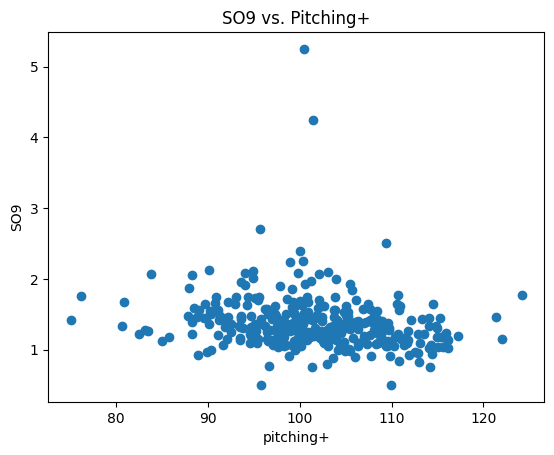

In [224]:
from pybaseball import pitching_stats_bref
import matplotlib.pyplot as plt

data = pitching_stats_bref(2023)

agg_sp = pd.read_csv('../../Downloads/stuff+ 2023 - Sheet1.csv')

agg_total[['Last Name', 'First Name']] = agg_total['player_name'].str.split(', ', expand=True)
agg_total['Full Name'] = agg_total['First Name'] + ' ' + agg_total['Last Name']
# agg_total = agg_total.merge(agg_sp, left_on=['Full Name'], right_on=['Name'], how='inner')
stats_pitching = data.merge(agg_total, left_on='Name', right_on='Full Name', how='inner')

x = stats_pitching['pitching_plus']
y = stats_pitching['WHIP']

plt.scatter(x, y)
plt.xlabel('pitching+')
plt.ylabel('SO9')
plt.title('SO9 vs. Pitching+')

corr_matrix = np.corrcoef(x, y)
corr = corr_matrix[0,1]
print(f'Coorelation: {corr}')

# Show the plot
plt.show()

In [153]:
[c for c in data.columns]

['Name',
 'Age',
 '#days',
 'Lev',
 'Tm',
 'G',
 'GS',
 'W',
 'L',
 'SV',
 'IP',
 'H',
 'R',
 'ER',
 'BB',
 'SO',
 'HR',
 'HBP',
 'ERA',
 'AB',
 '2B',
 '3B',
 'IBB',
 'GDP',
 'SF',
 'SB',
 'CS',
 'PO',
 'BF',
 'Pit',
 'Str',
 'StL',
 'StS',
 'GB/FB',
 'LD',
 'PU',
 'WHIP',
 'BAbip',
 'SO9',
 'SO/W',
 'mlbID']

In [154]:
joblib.dump(woba_model, 'pitching_woba_fb.joblib')
joblib.dump(take_model, 'pitching_take_fb.joblib')
joblib.dump(will_swing_model, 'pitching_ws_fb.joblib')
joblib.dump(swing_model, 'pitching_swing_fb.joblib')

joblib.dump(woba_bb_model, 'pitching_woba_bb.joblib')
joblib.dump(take_bb_model, 'pitching_take_bb.joblib')
joblib.dump(will_swing_bb_model, 'pitching_ws_bb.joblib')
joblib.dump(swing_bb_model, 'pitching_swing_bb.joblib')

joblib.dump(woba_offs_model, 'pitching_woba_offs.joblib')
joblib.dump(take_offs_model, 'pitching_take_offs.joblib')
joblib.dump(will_swing_offs_model, 'pitching_ws_offs.joblib')
joblib.dump(swing_offs_model, 'pitching_swing_offs.joblib')

['pitching_swing_offs.joblib']